# Import packages

In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os

Populating the interactive namespace from numpy and matplotlib


/Users/pradyumna/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# For rpy2

import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice

# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


TypeError: consoleWarn() missing 1 required positional argument: 'x'

/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/Users/pradyumna/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [4]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(pbkrtest)
library(broom)
library(dplyr)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(graphics)

## Extra Functions

In [5]:
def CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data_exp1):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_exp1, x= x_variable, y=y_variable, fit_reg=False, ci=0, color='#000000', scatter_kws={'s':70})
    #sns.regplot(data=data_exp1, x='AbsDiffValue', y='Confidence', fit_reg=False, ci=0, color='Black', scatter_kws={'s':50})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)
    #exp1 = mpatches.Patch(color='#000000', label='Experiment c1')
    #exp2 = mpatches.Patch(color='#AAAAAA', label='Experiment 2')
    #plt.legend(handles=[exp1, exp2], loc=3)
    x=data_exp1[x_variable]
    y=data_exp1[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    ax.plot(future, future_fit, color='Green', lw=3)
    sns.despine()
    #ax.set_title('Like + Dislike Condition')

    results = pearsonr(data_exp1[x_variable], data_exp1[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))


## Load data

In [6]:
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv')
Like_sufix = '_Like_FixBin5_Attempt2'
glam_full_like_estimates = np.load(str('CompareLikeDislike/estimates/glam_FF2018_full_hierarchical_cv'+Like_sufix+'.npy'))   

## Import gamma attentional parameters 

In [7]:
params_part_like = pd.DataFrame.from_dict(glam_full_like_estimates.item(0))
params_part_like.gamma

0    -0.45
1    -0.08
2     0.38
3    -0.59
4    -0.61
5    -0.29
6    -0.63
7    -0.48
8    -0.97
9    -0.48
10   -0.33
11   -0.54
12   -0.54
13   -0.23
14    0.03
15   -0.56
16   -0.58
17   -0.53
18   -0.87
19   -0.83
20   -0.86
21   -0.49
22   -0.61
23   -0.63
24   -0.14
25   -0.51
26   -0.95
27   -0.12
28   -0.86
29   -0.92
30   -0.87
31   -0.95
32   -0.66
Name: gamma, dtype: float64

In [8]:
# take out unnecesary columns
data = data.drop(['Unnamed: 0'], axis=1)

## Calculate Absolute Evidence values per trial 

In [9]:
z_matrix=[]
z_matrix_aux=[]

for i in (data['subject'].unique()):
    Choicedata = data.loc[data['subject'] == i]    
    gamma = [params_part_like.gamma[i]]*len(Choicedata)
    tau = [params_part_like.tau[i]]*len(Choicedata)
    abs_evid_0 = Choicedata.gaze_0 * Choicedata.item_value_0 + (1-Choicedata.gaze_0) * Choicedata.item_value_0*gamma
    abs_evid_1 = Choicedata.gaze_1 * Choicedata.item_value_1 + (1-Choicedata.gaze_1) * Choicedata.item_value_1*gamma
    R0_star= abs_evid_0 - abs_evid_1
    R1_star= abs_evid_1 - abs_evid_0
    #  Calculate Relative evidence using alternative trnasformation
    R0=(R0_star-R0_star.min())/(R0_star.max()-R0_star.min())
    R1=(R1_star-R1_star.min())/(R1_star.max()-R1_star.min())
    
    #  Calculate Relative evidence using GLAM trnasformation
    R0_glam=1/(1+exp(-R0_star*0.34))
    R1_glam=1/(1+exp(-R1_star*0.34))
    
    z_matrix_aux= np.column_stack((gamma,abs_evid_0,abs_evid_1,R0_star,R1_star,R0,R1,R0_glam,R1_glam))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
    # Add to aggregate table
    
aggregate_trial = np.column_stack((data,z_matrix))
data1 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","R0_glam","R1_glam"])

data1.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,abs_evid_1,R0_star,R1_star,R0,R1,R0_glam,R1_glam
0,0.0,0.0,2009.0,0.0,0.0,0.0,0.568396,0.431604,-0.45,0.000000,0.000000,0.000000,0.000000,0.420407,0.579593,0.500000,0.500000
1,0.0,1.0,3371.0,0.0,5.0,4.0,0.762332,0.237668,-0.45,3.276906,-0.421525,3.698430,-3.698430,1.000000,0.000000,0.778590,0.221410
2,0.0,2.0,1700.0,1.0,0.0,5.0,0.446809,0.553191,-0.45,0.000000,1.760638,-1.760638,1.760638,0.144491,0.855509,0.354660,0.645340
3,0.0,3.0,7466.0,1.0,1.0,2.0,0.532352,0.467648,-0.45,0.321911,0.456179,-0.134268,0.134268,0.399365,0.600635,0.488589,0.511411
4,0.0,4.0,1889.0,1.0,5.0,5.0,0.529736,0.470264,-0.45,1.590589,1.159411,0.431177,-0.431177,0.487978,0.512022,0.536585,0.463415


In [10]:
DAbsEvi= data1.abs_evid_1 - data1.abs_evid_0
DR= data1.R1 - data1.R0
DR_glam= data1.R1_glam - data1.R0_glam

DVal = data1.item_value_1 - data1.item_value_0
DGaze = data1.gaze_1 - data1.gaze_0

# Given like condition
# Create column for correct/incorrect 
# 1: correct 2: incorrect 

correct = np.where(data['item_value_1']>=data['item_value_0'], 1, 0)

## Notation used for evidence terms used in GLAM

DA = DAbsEvi = data1.abs_evid_1 - data1.abs_evid_0  with Ai equation in Thomas et al. (2017)

Considering Rstar_i = Ai - A(no_i) 

Ri = F1(Rstar_i) and transformation F1 given by (Ri_star-Ri_star.min())/(Ri_star.max()-Ri_star.min())

Ri_glam = F2(Rstar_i) and transformation F2 given by 1/(1+exp(-Ri_star*0.34))

DR = R1 -R0

DR_glam = R1_glam -R0_glam

             

In [11]:
data1["DAbsEvi"] = DAbsEvi
data1["DR"] = DR
data1["DR_glam"] = DR_glam
data1["DV"] = DVal
data1["AbsDV"] = DVal.abs()
data1["DGaze"] = DGaze
data1["correct"] = correct

In [12]:
data1.loc[data['subject'] == 3].head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,R1,R0_glam,R1_glam,DAbsEvi,DR,DR_glam,DV,AbsDV,DGaze,correct
360,3.0,0.0,3916.0,0.0,0.0,0.0,0.686415,0.313585,-0.59,0.000000,...,0.506396,0.500000,0.500000,0.000000,0.012791,0.000000,0.0,0.0,-0.372829,1
361,3.0,1.0,2427.0,0.0,5.0,2.0,0.726171,0.273829,-0.59,2.823058,...,0.129716,0.743640,0.256360,-3.132281,-0.740568,-0.487280,-3.0,3.0,-0.452342,0
362,3.0,2.0,3746.0,1.0,1.0,1.0,0.421530,0.578470,-0.59,0.080232,...,0.536404,0.478802,0.521198,0.249535,0.072808,0.042396,0.0,0.0,0.156941,1
363,3.0,3.0,3621.0,0.0,3.0,1.0,0.919054,0.080946,-0.59,2.613885,...,0.136583,0.739922,0.260078,-3.075181,-0.726835,-0.479843,-2.0,2.0,-0.838107,0
364,3.0,4.0,2167.0,1.0,4.0,3.0,0.293122,0.706878,-0.59,-0.495746,...,0.758642,0.328899,0.671101,2.097556,0.517284,0.342202,-1.0,1.0,0.413757,0


## Calculate Z-values 


In [13]:
z_matrix=[]
z_matrix_aux=[]

for i in (data1['subject'].unique()):
    Choicedata = data1.loc[data['subject'] == i]    
    
    pX_RT = pd.to_numeric(Choicedata["rt"]) 
    pX_zRT = (pX_RT - np.mean(pX_RT))/np.std(pX_RT)

    pX_DAbsEvi = pd.to_numeric(Choicedata["DAbsEvi"]) 
    pX_zDAbsEvi = (pX_DAbsEvi - np.mean(pX_DAbsEvi))/np.std(pX_DAbsEvi)
    
    pX_DR = pd.to_numeric(Choicedata["DR"]) 
    pX_zDR = (pX_DR - np.mean(pX_DR))/np.std(pX_DR)
    
    pX_DR_glam = pd.to_numeric(Choicedata["DR_glam"]) 
    pX_zDR_glam = (pX_DR_glam - np.mean(pX_DR_glam))/np.std(pX_DR_glam)

    pX_DV = pd.to_numeric(Choicedata["DV"]) 
    pX_zDV = (pX_DV - np.mean(pX_DV))/np.std(pX_DV)

    pX_DG = pd.to_numeric(Choicedata["DGaze"]) 
    pX_zDG = (pX_DG - np.mean(pX_DG))/np.std(pX_DG)

    
    z_matrix_aux= np.column_stack((pX_zRT,pX_zDAbsEvi,pX_zDR,pX_zDR_glam,pX_zDV,pX_zDG))
    
    for  j in range(len(z_matrix_aux)):    
        z_matrix.append(z_matrix_aux[j])
# Add to aggregate table
aggregate_trial = np.column_stack((data1,z_matrix))
data2 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","R0_glam","R1_glam","DA","DR","DR_glam","DV","AbsDV","DG","correct","z_rt","z_DA","z_DR","z_DR_glam","z_DV","z_DG"])


In [14]:
TotV= data2.item_value_0 + data1.item_value_1
data2["TotV"] = TotV

In [15]:
data2.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,AbsDV,DG,correct,z_rt,z_DA,z_DR,z_DR_glam,z_DV,z_DG,TotV
0,0.0,0.0,2009.0,0.0,0.0,0.0,0.568396,0.431604,-0.45,0.000000,...,0.0,-0.136792,1.0,-0.599044,0.109683,0.109683,0.108939,0.000000,-0.399816,0.0
1,0.0,1.0,3371.0,0.0,5.0,4.0,0.762332,0.237668,-0.45,3.276906,...,1.0,-0.524664,0.0,0.289097,-2.587191,-2.587191,-2.377414,-0.360375,-2.127093,9.0
2,0.0,2.0,1700.0,1.0,0.0,5.0,0.446809,0.553191,-0.45,0.000000,...,5.0,0.106383,1.0,-0.800539,1.393530,1.393530,1.406067,1.801875,0.683098,5.0
3,0.0,3.0,7466.0,1.0,1.0,2.0,0.532352,0.467648,-0.45,0.321911,...,1.0,-0.064704,1.0,2.959390,0.207591,0.207591,0.210779,0.360375,-0.078791,3.0
4,0.0,4.0,1889.0,1.0,5.0,5.0,0.529736,0.470264,-0.45,1.590589,...,0.0,-0.059473,1.0,-0.677295,-0.204729,-0.204729,-0.217570,0.000000,-0.055494,10.0


# Choice Regressions
----------------------------------------------

In [16]:
%%R -i data2
datas  <- data2

BIC: 4811.294

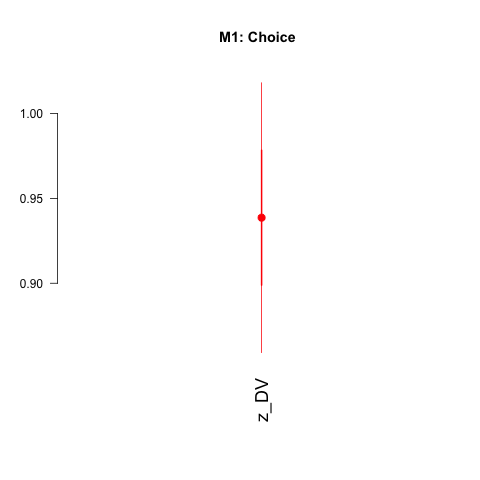

In [17]:
%%R    
title_plot = "M1: Choice  "
ModelChoice_1 <- glm(choice ~ z_DV, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)

BIC: 3619.724

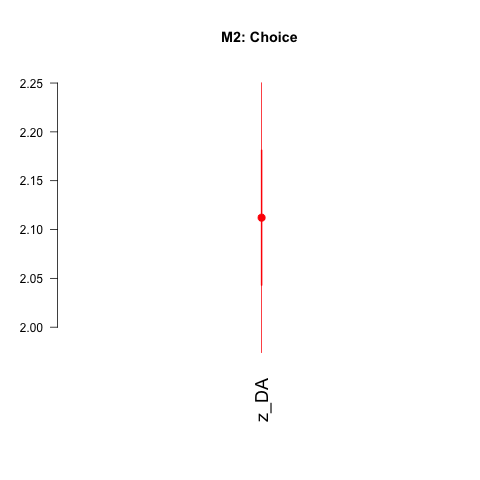

In [18]:
%%R    
title_plot = "M2: Choice "
ModelChoice_2 <- glm(choice ~ z_DA, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_2,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC2 = BIC(ModelChoice_2)
cat("BIC:" , BIC2)

BIC: 4063.237

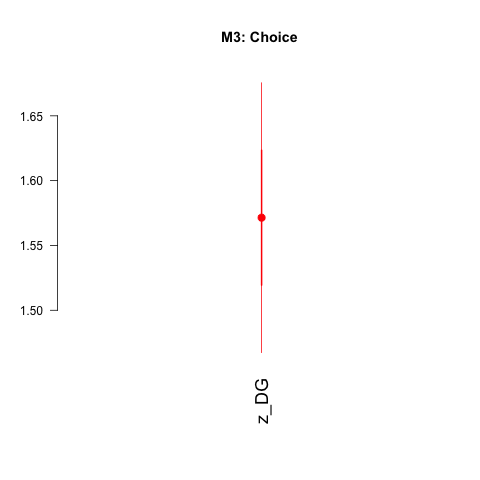

In [19]:
%%R    
title_plot = "M3: Choice "
ModelChoice_3 <- glm(choice ~ z_DG , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_3,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC3 = BIC(ModelChoice_3)
cat("BIC:" , BIC3)

BIC: 3619.724

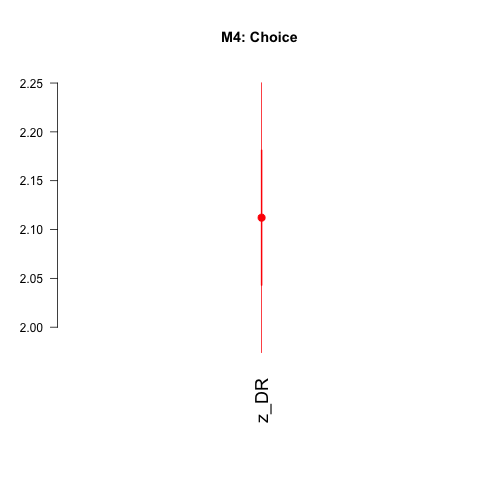

In [20]:
%%R    
title_plot = "M4: Choice "
ModelChoice_4 <- glm(choice ~ z_DR, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_4,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC4 = BIC(ModelChoice_4)
cat("BIC:" , BIC4)

BIC: 3577.779

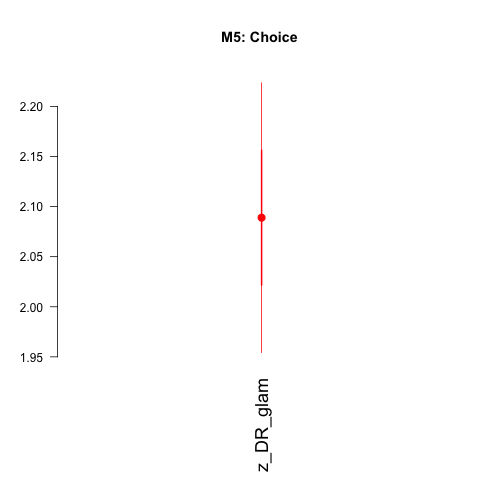

In [21]:
%%R    
title_plot = "M5: Choice "
ModelChoice_5 <- glm(choice ~ z_DR_glam, data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_5,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC5 = BIC(ModelChoice_5)
cat("BIC:" , BIC5)

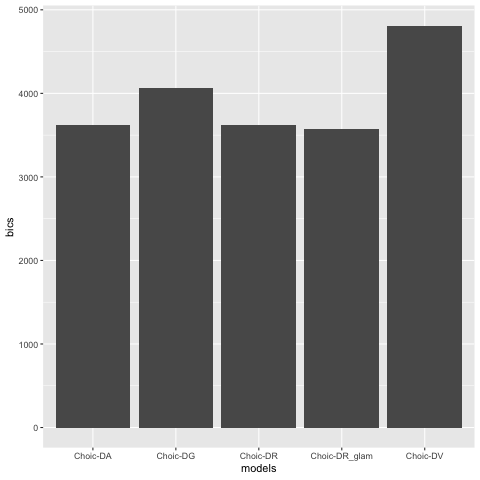

In [22]:
%%R
models  <- rep(c('Choic-DV','Choic-DA','Choic-DG','Choic-DR','Choic-DR_glam'))
bics  <- c(BIC1,BIC2,BIC3,BIC4,BIC5)
BICdf<-data.frame(models,bics)
p <-ggplot(BICdf, aes(models,bics))
p +geom_bar(stat = "identity")

BIC: 3546.663

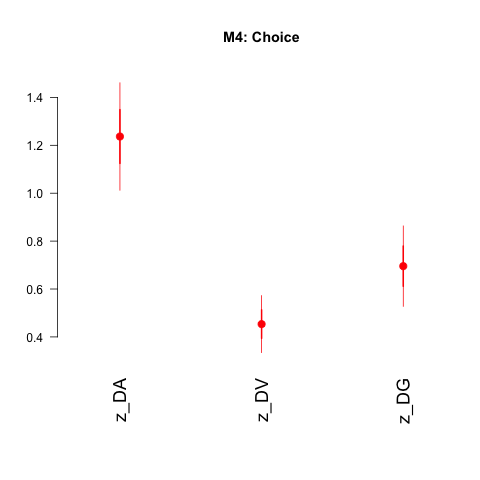

In [23]:
%%R    
title_plot = "M4: Choice"
ModelChoice_e1 <- glm(choice ~ z_DA+ z_DV + z_DG , data= datas, family=binomial(link="logit"))
coefplot(ModelChoice_e1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICe1 = BIC(ModelChoice_e1)
cat("BIC:" , BICe1)

## Correct / Incorrect and RT
------------------------------------------
How to model the accumulation of evidence?
Do we observe from the data that RT is dependent on the difference in relative evidence? In this case DV should present an effect over the proportion of correct and incorrect. Is it dependant on the Value of the options (high value --> high evidence)? In this case we should answer better when the value of items is higher.

BIC: 4929.968
Call:  glm(formula = correct ~ rt + AbsDV + TotV, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)           rt        AbsDV         TotV  
  1.481e+00   -3.175e-05   -4.240e-01   -2.074e-02  

Degrees of Freedom: 3959 Total (i.e. Null);  3956 Residual
Null Deviance:	    5260 
Residual Deviance: 4897 	AIC: 4905


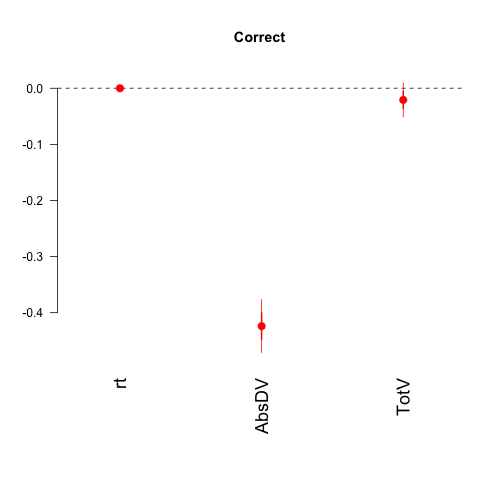

In [24]:
%%R
title_plot = " Correct  "
ModelCorrect_1 <- glm(correct ~ rt + AbsDV +TotV , data= datas, family=binomial(link="logit"))
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

BIC: 5276.069
Call:  glm(formula = correct ~ rt, family = binomial(link = "logit"), 
    data = datas)

Coefficients:
(Intercept)           rt  
  4.754e-01    4.927e-06  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    5260 
Residual Deviance: 5260 	AIC: 5264


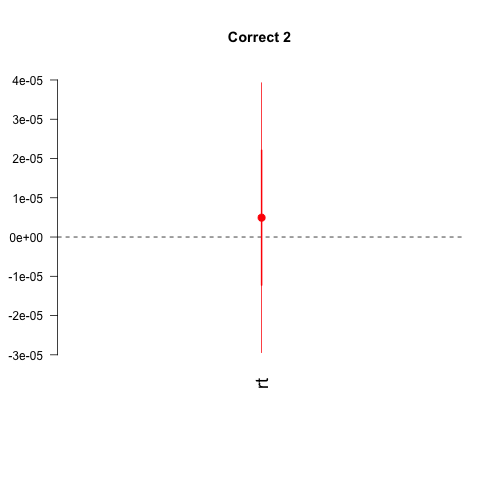

In [25]:
%%R
title_plot = " Correct 2  "
ModelCorrect_2 <- glm(correct ~ rt , data= datas, family=binomial(link="logit"))
coefplot(ModelCorrect_2,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc2 = BIC(ModelCorrect_2)
cat("BIC:" , BICc2)
ModelCorrect_2

In [26]:
#  x_variable = 'correct'
#  x_varlabel = 'Correct'
#  y_variable = 'rt'
#  y_varlabel =  'RT'
#  CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)
#  
#  x_variable = 'correct'
#  x_varlabel = 'Correct'
#  y_variable = 'AbsDV'
#  y_varlabel =  '|DV|'
#  CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)
#  
#  x_variable = 'correct'
#  x_varlabel = 'Correct'
#  y_variable = 'TotV'
#  y_varlabel =  'TotalValue'
#  CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)

Looks like if we try to predict rt, DV has an effect, making faster responses when there are bigger differences between the items. In the case of TotValue, looks like when the items are more valuable the decision take more time. This looks oposed to the models of accumulation of evidence that Marius proposed.

BIC: 71085.18
Call:  glm(formula = rt ~ correct + AbsDV + TotV + correct:AbsDV, data = datas)

Coefficients:
  (Intercept)        correct          AbsDV           TotV  correct:AbsDV  
      3118.68        -253.45        -196.26          31.83          66.94  

Degrees of Freedom: 3959 Total (i.e. Null);  3955 Residual
Null Deviance:	    1.452e+10 
Residual Deviance: 1.431e+10 	AIC: 71050


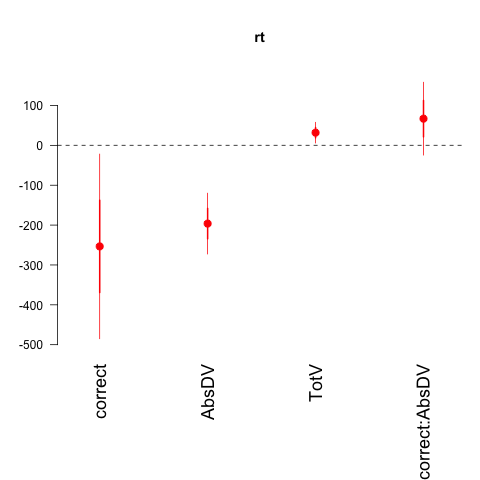

In [27]:
%%R
title_plot = " rt  "
ModelCorrect_1 <- glm(rt ~ correct + AbsDV +TotV + correct:AbsDV,  data= datas)
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICc1 = BIC(ModelCorrect_1)
cat("BIC:" , BICc1)
ModelCorrect_1

In [28]:
# x_variable = 'rt'
# x_varlabel =  'RT'
# y_variable = 'AbsDV'
# y_varlabel =  '|DV|'
# CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)
# 
# x_variable = 'rt'
# x_varlabel =  'RT'
# y_variable = 'TotV'
# y_varlabel =  'TotalValue'
# CorrPlot(x_variable,x_varlabel,y_variable,y_varlabel,data2)

# Accumulator model
---------------------------------------------------------------

In [29]:
## Load fixation sequence
data_fix = pd.read_csv('data/FF2018_data/fixations_seq_Like.csv')

In [30]:
data_fix.head()

,parcode,trial,fix_item,fix_time
0,0,0,3,313
1,0,0,1,258
2,0,0,1,294
3,0,0,2,342
4,0,0,2,286


In [31]:
# We wont consider accumulation of evidence in the case the participant doesn't observe the IA

In [32]:
IAFixMatrix = []

for i in (data_fix['parcode'].unique()):
    PartIAFixMatrix= data_fix.loc[(data_fix['parcode'] == i )]
    trialNums = pd.unique(PartIAFixMatrix["trial"])
    for j in trialNums:
        
        PartTrialIAFixMatrix= PartIAFixMatrix.loc[(PartIAFixMatrix['trial'] == j )]
        # considering that IA 1 is left and IA 2 is right ( IAs 3 and 0 are not fixated in the item)
        # I won't consider time in this case
        FixSequence = PartTrialIAFixMatrix.loc[(PartTrialIAFixMatrix['fix_item'] != 0) & (PartTrialIAFixMatrix['fix_item'] != 3), 'fix_item']
        FixSequence = FixSequence.values
        #LGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 1, 'fix_time'].sum() 
        ## Sum right item
        #RGazeTime = PartTrialIAFixMatrix.loc[PartTrialIAFixMatrix['fix_item'] == 2, 'fix_time'].sum()  
        #LGaze = LGazeTime/(LGazeTime + RGazeTime)
        #RGaze = RGazeTime/(LGazeTime + RGazeTime)
        
        IAFixMatrix.append(FixSequence) 

In [33]:
len(IAFixMatrix)

3960

In [34]:
# Add to aggregate dataframe
aggregate_trial = np.column_stack((data2,IAFixMatrix))
data3 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","R0_glam","R1_glam","DA","DR","DR_glam","DV","AbsDV","DG","correct","z_rt","z_DA","z_DR","z_DR_glam","z_DV","z_DG","TotV","fix_seq"])

In [35]:
data3.fix_seq[3]
data3.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,DG,correct,z_rt,z_DA,z_DR,z_DR_glam,z_DV,z_DG,TotV,fix_seq
0,0,0,2009,0,0,0,0.568396,0.431604,-0.45,0,...,-0.136792,1,-0.599044,0.109683,0.109683,0.108939,0,-0.399816,0,"[1, 1, 2, 2, 2, 1]"
1,0,1,3371,0,5,4,0.762332,0.237668,-0.45,3.27691,...,-0.524664,0,0.289097,-2.58719,-2.58719,-2.37741,-0.360375,-2.12709,9,"[1, 1, 1, 2, 2, 1, 1, 1, 1, 1]"
2,0,2,1700,1,0,5,0.446809,0.553191,-0.45,0,...,0.106383,1,-0.800539,1.39353,1.39353,1.40607,1.80187,0.683098,5,"[1, 1, 1, 2, 2]"
3,0,3,7466,1,1,2,0.532352,0.467648,-0.45,0.321911,...,-0.0647042,1,2.95939,0.207591,0.207591,0.210779,0.360375,-0.0787912,3,"[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, ..."
4,0,4,1889,1,5,5,0.529736,0.470264,-0.45,1.59059,...,-0.0594727,1,-0.677295,-0.204729,-0.204729,-0.21757,0,-0.055494,10,"[1, 1, 1, 1, 2, 2]"


# Assigning paramters for Accumulator simulations.

The equations for the accumulators are 

$x_{L}$(t+1) = $\lambda$$x_{L}$(t) + $\beta$$I_{L}$




$x_{R}$(t+1) = $\lambda$$x_{R}$(t) + $\beta$$I_{R}$

$I_{L}$ and $I_{R}$: works as unit ot be accumulated during each time point (in this case each fixation). If participant is not fixing the item, they accumulate half evidence for that item. Evidence unit available to be accumulated will be the value of the item indicated by item_value_0 and item_value_1, respectively.

In [36]:
# Simple initial approach with  no decay, no lateral inhibition and 0.5 bias when item is not being fixated
lambd = 1
beta = 1
gama = 0.5 # Attention

In [37]:
# initialize accumulators vectors. We will generate an accumulator vector for right and left options
# for each trial
x_L_seq = []
x_R_seq = []
x_L_last = []
x_R_last = []
Dx_last=[]
Abs_Dx_last = []

for i in (data3['subject'].unique()):
    SubjectMatrix= data3.loc[(data3['subject'] == i )]
    trialNums = pd.unique(PartIAFixMatrix["trial"])
    for j in trialNums:
        TrialMatrix= SubjectMatrix.loc[(SubjectMatrix['trial'] == j )]
        FixSeq = TrialMatrix.fix_seq.values[0]
        x_L = [0]
        x_R = [0]
        for k in range(len(FixSeq)):
            if FixSeq[k] == 0: # if fixation is item left (0)
                x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta
                x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta*gama
            if FixSeq[k] == 1: # if fixation is item right (1)
                x_L_now = x_L[-1]*lambd + TrialMatrix.item_value_0.values[0]*beta*gama
                x_R_now = x_L[-1]*lambd + TrialMatrix.item_value_1.values[0]*beta    
            
            x_L.append(x_L_now) 
            x_R.append(x_R_now) 
        x_L_seq.append(x_L) 
        x_R_seq.append(x_R) 
        x_L_last.append(x_L[-1])
        x_R_last.append(x_R[-1])
        Dx_last.append(x_R[-1]-x_L[-1])
        Abs_Dx_last.append(abs(x_R[-1]-x_L[-1]))

In [38]:
aggregate_trial = np.column_stack((data3,x_L_seq,x_R_seq,x_L_last,x_R_last,Dx_last,Abs_Dx_last))
data4 = pd.DataFrame(aggregate_trial,columns=["subject","trial","rt","choice","item_value_0","item_value_1","gaze_0","gaze_1","gamma","abs_evid_0","abs_evid_1","R0_star","R1_star","R0","R1","R0_glam","R1_glam","DA","DR","DR_glam","DV","AbsDV","DG","correct","z_rt","z_DA","z_DR","z_DR_glam","z_DV","z_DG","TotV","fix_seq","L_Acc","R_Acc","L_last","R_last","Dx_last","Abs_Dx_last"])

In [39]:
data4.head()

,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,gamma,abs_evid_0,...,z_DV,z_DG,TotV,fix_seq,L_Acc,R_Acc,L_last,R_last,Dx_last,Abs_Dx_last
0,0,0,2009,0,0,0,0.568396,0.431604,-0.45,0,...,0,-0.399816,0,"[1, 1, 2, 2, 2, 1]","[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,0,0,0
1,0,1,3371,0,5,4,0.762332,0.237668,-0.45,3.27691,...,-0.360375,-2.12709,9,"[1, 1, 1, 2, 2, 1, 1, 1, 1, 1]","[0, 2.5, 5.0, 7.5, 7.5, 7.5, 10.0, 12.5, 15.0,...","[0, 4.0, 6.5, 9.0, 9.0, 9.0, 11.5, 14.0, 16.5,...",20,21.5,1.5,1.5
2,0,2,1700,1,0,5,0.446809,0.553191,-0.45,0,...,1.80187,0.683098,5,"[1, 1, 1, 2, 2]","[0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 5.0, 5.0, 5.0, 5.0, 5.0]",0,5,5,5
3,0,3,7466,1,1,2,0.532352,0.467648,-0.45,0.321911,...,0.360375,-0.0787912,3,"[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, ...","[0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 2.5, 3....","[0, 2.0, 2.5, 2.5, 2.5, 2.5, 3.0, 3.5, 4.0, 4....",6.5,8,1.5,1.5
4,0,4,1889,1,5,5,0.529736,0.470264,-0.45,1.59059,...,0,-0.055494,10,"[1, 1, 1, 1, 2, 2]","[0, 2.5, 5.0, 7.5, 10.0, 10.0, 10.0]","[0, 5.0, 7.5, 10.0, 12.5, 12.5, 12.5]",10,12.5,2.5,2.5


## Load extra confidence information

In [40]:
data_all_4 = pd.read_csv('data/FF2018_data/FFAllData_Like.csv')

#drop columns with many datapoints
data_all_4 = data_all_4.drop(['Unnamed: 0'], axis=1)

#data_all_4 = data_all_4.drop(['fix_seq'], axis=1)
#data_all_4 = data_all_4.drop(['L_Acc'], axis=1)
#data_all_4 = data_all_4.drop(['R_Acc'], axis=1)

In [41]:
data_all_4.head()
data5 = pd.concat([data4, data_all_4],axis=1)

In [42]:
# To avoid problem of inexplicable transposition of the columns
data5.to_csv('data/FF2018_data/Aggregate_Acc_Data_All_Like.csv',index = False)
data5 = pd.read_csv('data/FF2018_data/Aggregate_Acc_Data_All_Like.csv')

## Calculate z-values for accumulator measures

In [43]:
zDx_last=[]
zAbs_Dx_last=[]

for i in (data5['subject'].unique()):
    Choicedata = data5.loc[data5['subject'] == i]    
    
    pX_Dx_last = pd.to_numeric(Choicedata["Dx_last"].values) 
    pX_zDx_last = (pX_Dx_last - np.mean(pX_Dx_last))/np.std(pX_Dx_last)

    pX_Abs_Dx_last = pd.to_numeric(Choicedata["Abs_Dx_last"].values) 
    pX_zAbs_Dx_last = (pX_Abs_Dx_last - np.mean(pX_Abs_Dx_last))/np.std(pX_Abs_Dx_last)
    
    #z_matrix_aux= np.column_stack((pX_zRT,pX_zDAbsEvi,pX_zDR,pX_zDV,pX_zDG))
    
    for  j in range(len(pX_zAbs_Dx_last)):    
        zDx_last.append(pX_zDx_last[j])
        zAbs_Dx_last.append(pX_zAbs_Dx_last[j])

In [44]:
data5['zDx_last']=zDx_last
data5['zAbs_Dx_last']=zAbs_Dx_last

# Let's add the absolute value of some additional measures

data5['z_AbsDA']=abs(data5.z_DA)
data5['z_AbsDR']=abs(data5.z_DR)
data5['z_AbsDG']=abs(data5.z_DG)
data5['z_AbsDR_glam']=abs(data5.z_DR_glam)

In [45]:
%%R -i data5
d <- data5



## Log regressions for accumulation of evidence

BIC: 4890.953

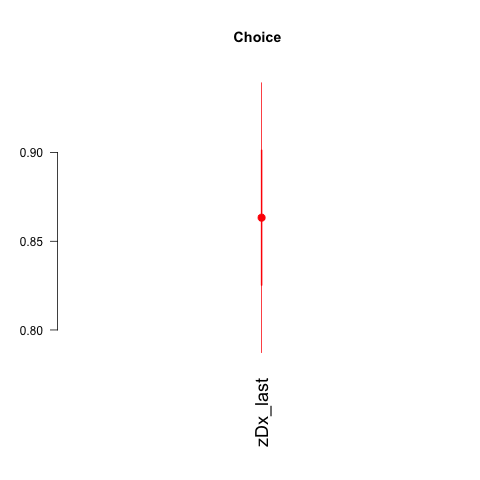

In [46]:
%%R    
title_plot = "Choice  "
ModelChoice_1 <- glm(Choice ~ zDx_last , data= d,family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC6 = BIC(ModelChoice_1)
cat("BIC:" , BIC6)

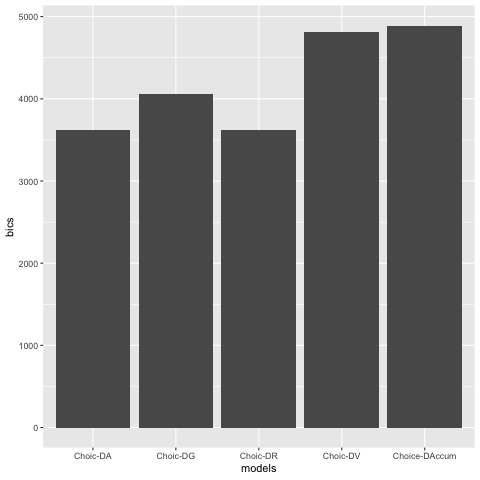

In [47]:
%%R
models  <- rep(c('Choic-DV','Choic-DA','Choic-DG','Choic-DR','Choice-DAccum'))
bics  <- c(BIC1,BIC2,BIC3,BIC4,BIC6)
BICdf<-data.frame(models,bics)

p <-ggplot(BICdf, aes(models,bics))
p +geom_bar(stat = "identity")

## Linear regression for confidence

BIC: 10844.92
Call:  glm(formula = zConf ~ zAbs_Dx_last, data = d)

Coefficients:
 (Intercept)  zAbs_Dx_last  
     0.09837       0.08012  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3563 	AIC: 10830


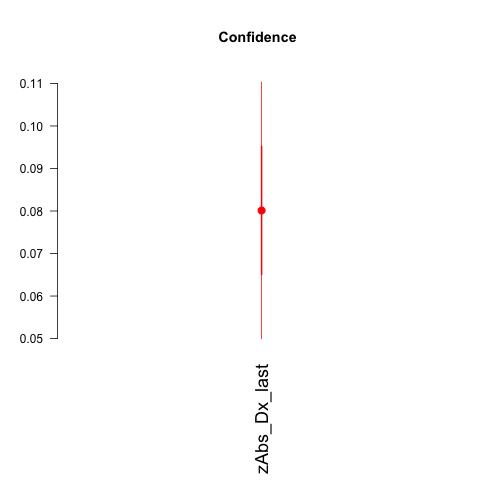

In [48]:
%%R    
title_plot = "Confidence  "
ModelConf_1 <- glm(zConf ~ zAbs_Dx_last , data= d)
coefplot(ModelConf_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1conf = BIC(ModelConf_1)
cat("BIC:" , BIC1conf)
ModelConf_1

BIC: 10724.55
Call:  glm(formula = zConf ~ zAbsDVal, data = d)

Coefficients:
(Intercept)     zAbsDVal  
    0.09867      0.18289  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3457 	AIC: 10710


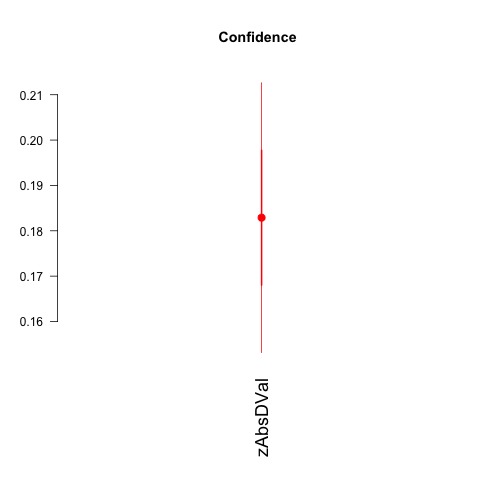

In [49]:
%%R    
title_plot = "Confidence  "
ModelConf_2 <- glm(zConf ~ zAbsDVal, data= d)
coefplot(ModelConf_2,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC2conf = BIC(ModelConf_2)
cat("BIC:" , BIC2conf)
ModelConf_2

BIC: 10830.77
Call:  glm(formula = zConf ~ z_AbsDR_glam, data = d)

Coefficients:
 (Intercept)  z_AbsDR_glam  
     -0.0315        0.1628  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3551 	AIC: 10810


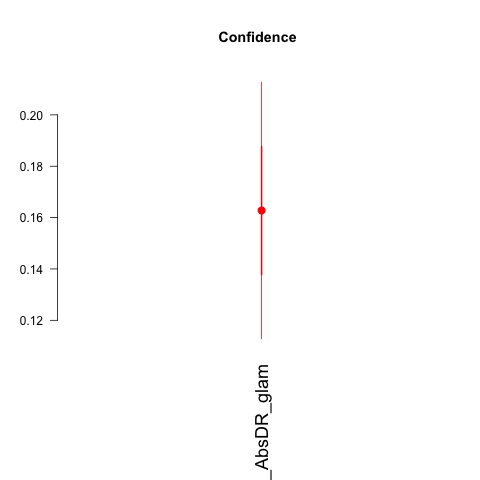

In [50]:
%%R    
title_plot = "Confidence  "
ModelConf_3 <- glm(zConf ~ z_AbsDR_glam, data= d)
coefplot(ModelConf_3,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC3conf = BIC(ModelConf_3)
cat("BIC:" , BIC3conf)
ModelConf_3

BIC: 10834.64
Call:  glm(formula = zConf ~ z_AbsDR, data = d)

Coefficients:
(Intercept)      z_AbsDR  
   -0.01924      0.15028  

Degrees of Freedom: 3959 Total (i.e. Null);  3958 Residual
Null Deviance:	    3589 
Residual Deviance: 3554 	AIC: 10820


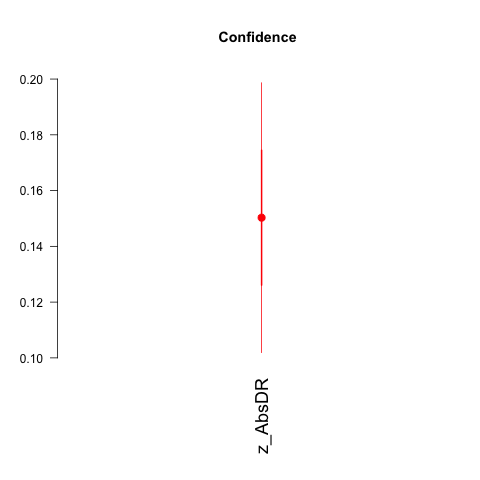

In [51]:
%%R    
title_plot = "Confidence  "
ModelConf_4 <- glm(zConf ~ z_AbsDR, data= d)
coefplot(ModelConf_4,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC4conf = BIC(ModelConf_4)
cat("BIC:" , BIC4conf)
ModelConf_4

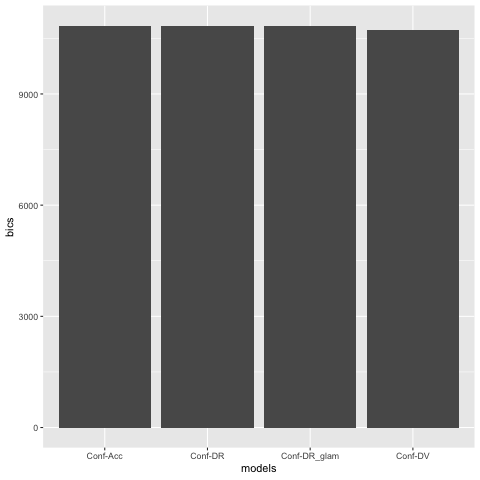

In [52]:
%%R
models  <- rep(c('Conf-Acc','Conf-DV','Conf-DR_glam','Conf-DR'))
bics  <- c(BIC1conf,BIC2conf,BIC3conf,BIC4conf)
BICdf<-data.frame(models,bics)

p <-ggplot(BICdf, aes(models,bics))
p +geom_bar(stat = "identity")

# Separating by alternative
------------------------------------------------------------------------

## Log regressions for Correct/Incorrect

BIC: 5235.976
Call:  glm(formula = correct ~ zChosenVal + zUnchosenVal, family = binomial(link = "logit"), 
    data = d)

Coefficients:
 (Intercept)    zChosenVal  zUnchosenVal  
      0.5854       -0.2306        0.0879  

Degrees of Freedom: 3959 Total (i.e. Null);  3957 Residual
Null Deviance:	    5260 
Residual Deviance: 5211 	AIC: 5217


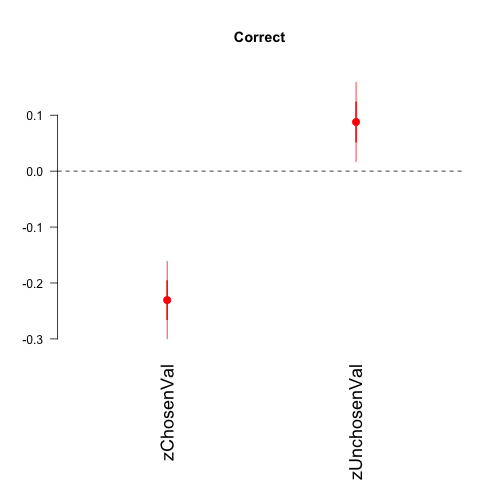

In [53]:
%%R
title_plot = " Correct  "
ModelCorrect_1 <- glm(correct ~ zChosenVal + zUnchosenVal  , data= d, family=binomial(link="logit"))
coefplot(ModelCorrect_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICco1 = BIC(ModelCorrect_1)
cat("BIC:" , BICco1)
ModelCorrect_1

##  Regressions for RT

BIC: 71051.18
Call:  glm(formula = rt ~ zChosenVal + zUnchosenVal, data = d)

Coefficients:
 (Intercept)    zChosenVal  zUnchosenVal  
      2936.3        -155.1         241.8  

Degrees of Freedom: 3959 Total (i.e. Null);  3957 Residual
Null Deviance:	    1.452e+10 
Residual Deviance: 1.425e+10 	AIC: 71030


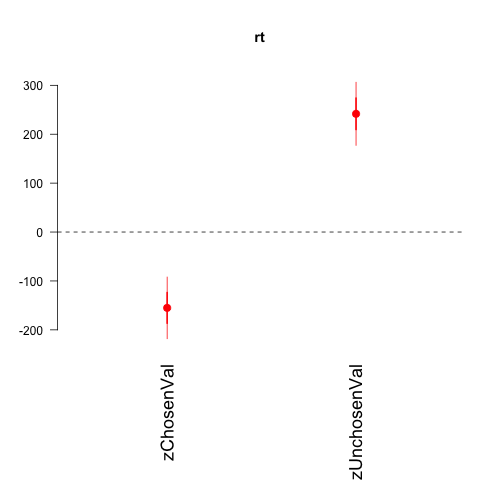

In [54]:
%%R
title_plot = " rt  "
ModelRt_1 <- glm(rt ~  zChosenVal + zUnchosenVal  ,  data= d)
coefplot(ModelRt_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BICrt1 = BIC(ModelRt_1)
cat("BIC:" , BICrt1)
ModelRt_1

## Extra Choice Regressions

BIC: 4786.087

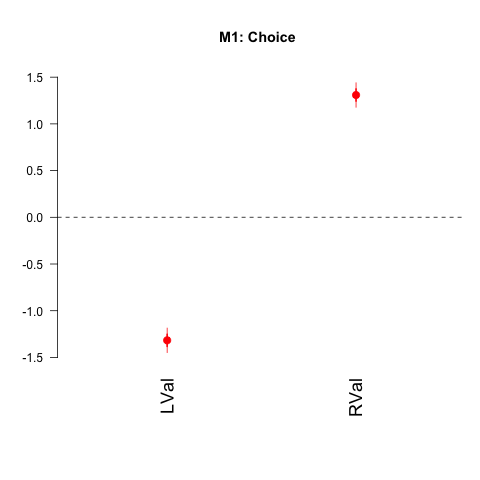

In [55]:
%%R    
title_plot = "M1: Choice  "
ModelChoice_1 <- glm(choice ~ LVal + RVal , data= d, family=binomial(link="logit"))
coefplot(ModelChoice_1,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC1 = BIC(ModelChoice_1)
cat("BIC:" , BIC1)

BIC: 3620.32

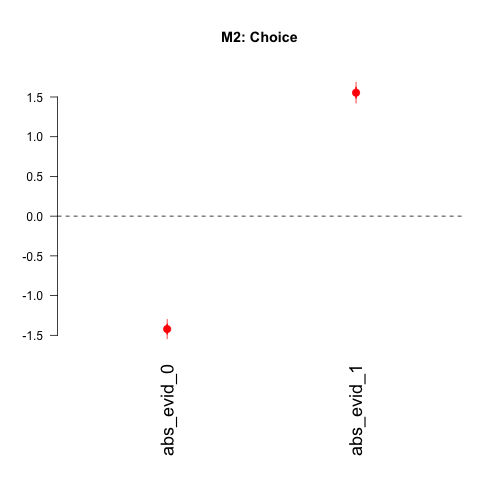

In [56]:
%%R    
title_plot = "M2: Choice "
ModelChoice_2 <- glm(choice ~ abs_evid_0 + abs_evid_1, data= d, family=binomial(link="logit"))
coefplot(ModelChoice_2,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC2 = BIC(ModelChoice_2)
cat("BIC:" , BIC2)

BIC: 4051.494

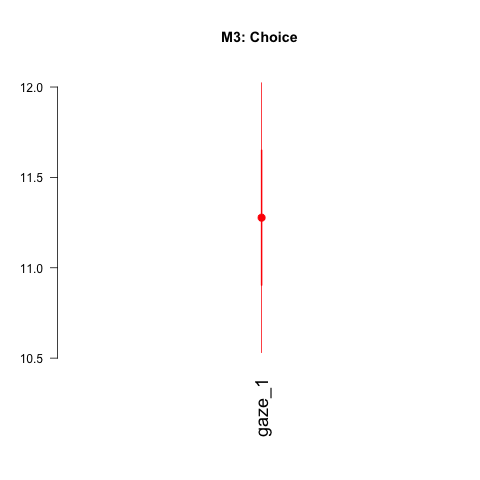

In [57]:
%%R    
title_plot = "M3: Choice "
ModelChoice_3 <- glm(choice ~  gaze_1  + gaze_0, data= d, family=binomial(link="logit"))
coefplot(ModelChoice_3,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC3 = BIC(ModelChoice_3)
cat("BIC:" , BIC3)

BIC: 3820.228

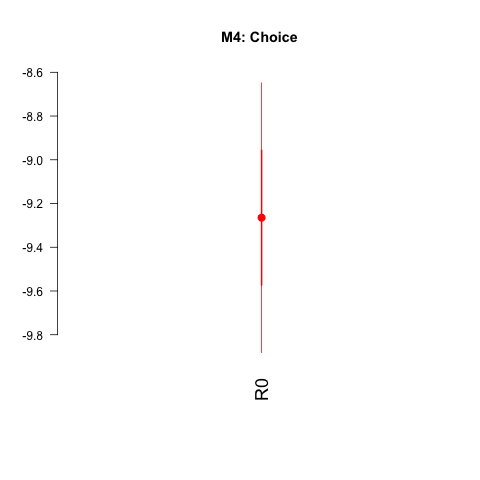

In [58]:
%%R    
title_plot = "M4: Choice "
ModelChoice_4 <- glm(choice ~ R0 + R1, data= d, family=binomial(link="logit"))
coefplot(ModelChoice_4,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC4 = BIC(ModelChoice_4)
cat("BIC:" , BIC4)

BIC: 3569.019

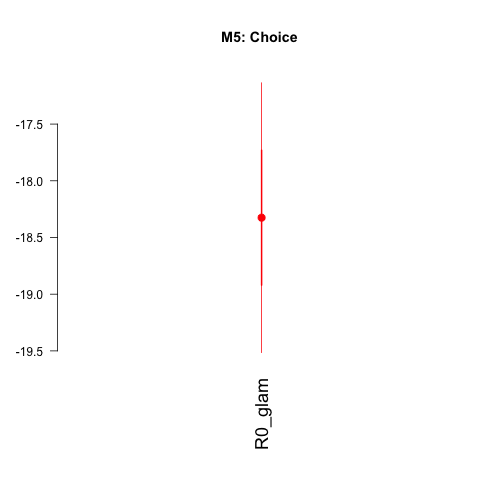

In [59]:
%%R    
title_plot = "M5: Choice "
ModelChoice_5 <- glm(choice ~ R0_glam + R1_glam, data= d, family=binomial(link="logit"))
coefplot(ModelChoice_5,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC5 = BIC(ModelChoice_5)
cat("BIC:" , BIC5)

BIC: 4935.121

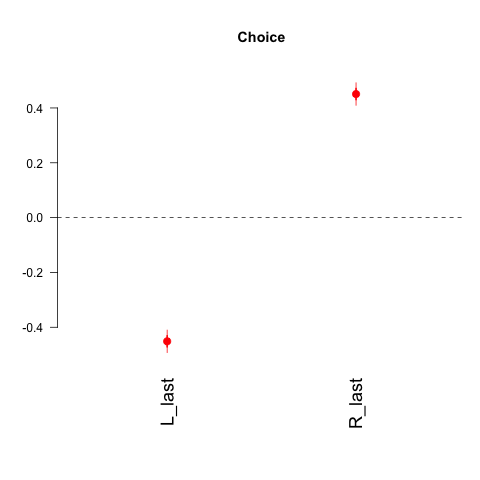

In [60]:
%%R    
title_plot = "Choice"
ModelChoice_6 <- glm(Choice ~ L_last + R_last , data= d,family=binomial(link="logit"))
coefplot(ModelChoice_6,intercept=FALSE,vertical = FALSE,  col.pts="red", cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),main=title_plot)
#legend("topright",  legend=c("Dislike", "Like"),col=c("red", "blue"), lty=1:1, cex=1)
BIC6 = BIC(ModelChoice_6)
cat("BIC:" , BIC6)

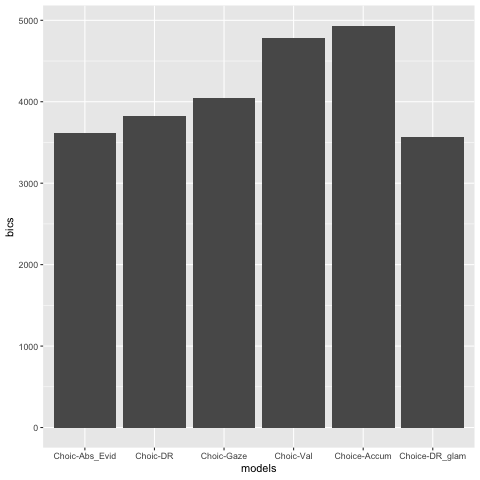

In [61]:
%%R
models  <- rep(c('Choic-Val','Choic-Abs_Evid','Choic-Gaze','Choic-DR','Choice-DR_glam','Choice-Accum'))
bics  <- c(BIC1,BIC2,BIC3,BIC4,BIC5,BIC6)
BICdf<-data.frame(models,bics)

p <-ggplot(BICdf, aes(models,bics))
p +geom_bar(stat = "identity")